## Review Sentiment Analysis
<p>Weight reviews from users with few total reviews differently, thinking is that users with only a handful of reviews are likely to be reviewing only for particularly good or bad experiences</p>

In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import math
import datetime

import nltk
from nltk.corpus import stopwords


import seaborn as sns
sns.set()
# sns.set_style('whitegrid')
# sns.set_context("poster")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Import Review Data - United States Restaurant Reviews Only

In [5]:
print('[%s] Loading Review Data...' % datetime.datetime.now().time())

morning_commutes = pd.DataFrame()
data_file = './clean_data/_analysis/restaurant_reviews_united_states.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(data_file, chunksize=chunksize, iterator=True, index_col=0):
        
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

reviews = pd.concat(chunks)
reviews.reset_index(inplace=True, drop=True)
print('[%s] Complete!' % datetime.datetime.now().time())

[19:00:17.950538] Loading Review Data...
		[19:00:23.259235] finished chunk 1 of 441
		[19:00:29.433824] finished chunk 45 of 441
		[19:00:36.725941] finished chunk 90 of 441
[19:00:45.844803] Complete!


In [6]:
reviews.head(3)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,review_length,state,city
0,-gTX7XKGOntF2FQ1EDxHpA,0,2016-07-21,0,8BJUlXtGvVpkNq663suBUw,1,went thru the drive thru and could hardly unde...,0,AKtCpeBdst-OFYNmsfJgiw,336,AZ,Litchfield Park
1,-gTX7XKGOntF2FQ1EDxHpA,1,2017-07-25,0,umGwYIfHbKjj5Tvi2o4Oog,1,everytime i come here something is wrong a few...,1,5vTqiawndUhSPAqDMhPr5Q,293,AZ,Litchfield Park
2,-gTX7XKGOntF2FQ1EDxHpA,1,2015-10-18,1,mjiQ2bNWFTbuzdQN0IVcJw,1,bad decision extra crispy was not rollsbiscui...,3,7-nbzoSmoMzwo2fbetoycQ,228,AZ,Litchfield Park


In [7]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323672 entries, 0 to 1323671
Data columns (total 12 columns):
business_id      1323672 non-null object
cool             1323672 non-null int64
date             1323672 non-null object
funny            1323672 non-null int64
review_id        1323672 non-null object
stars            1323672 non-null int64
text             1323672 non-null object
useful           1323672 non-null int64
user_id          1323672 non-null object
review_length    1323672 non-null int64
state            1323672 non-null object
city             1323672 non-null object
dtypes: int64(5), object(7)
memory usage: 121.2+ MB


In [8]:
reviews.describe()

,cool,funny,stars,useful,review_length
count,1.323672e+06,1.323672e+06,1.323672e+06,1.323672e+06,1.323672e+06
mean,5.071596e-01,4.008644e-01,3.688093e+00,9.134370e-01,5.666091e+02
std,1.990089e+00,1.644629e+00,1.376753e+00,2.389730e+00,5.341269e+02
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,2.190000e+02
50%,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,3.960000e+02
75%,0.000000e+00,0.000000e+00,5.000000e+00,1.000000e+00,7.250000e+02
max,2.170000e+02,1.640000e+02,5.000000e+00,2.170000e+02,4.941000e+03


## Exploration

<div class="span5 alert alert-info">
<b>Exporation:</b> Relationship between review text length and star rating
</div>

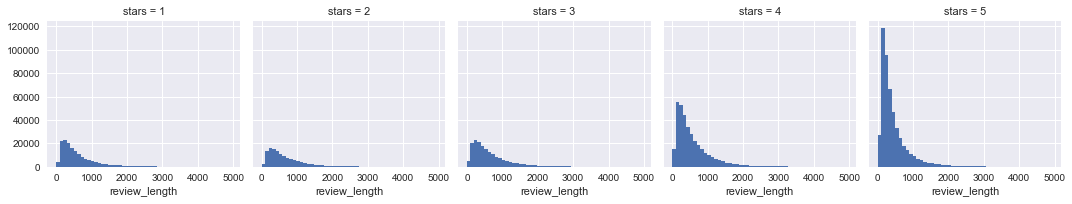

In [10]:
g = sns.FacetGrid(data=reviews, col='stars')
g.map(plt.hist, 'review_length', bins=50)

<div class="alert alert-success">
<b>Take Away:</b> Distribution seems similar for all star ratings, but there are a lot more 4 and 5 star reviews than 1, 2 or 3 star reviews
</div>

<div class="span5 alert alert-info">
<b>Exporation:</b> Length of reviews for each star rating
</div>

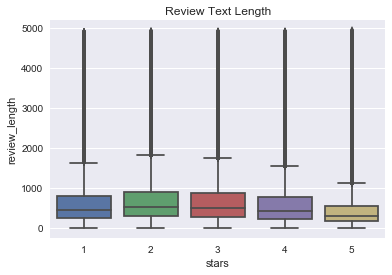

In [18]:
ax = sns.boxplot(x='stars', y='review_length', data=reviews)
ax.set_title('Review Text Length')
plt.show()
plt.close()

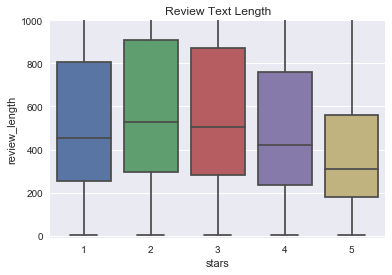

In [17]:
ax = sns.boxplot(x='stars', y='review_length', data=reviews)
ax.set_title('Review Text Length')
ax.set_ylim([-10,1000])
plt.show()
plt.close()

<div class="alert alert-success">
<b>Take Away:</b> 1 and 2 star reviews have text much longer than 4 or 5 star reviews
</div>

# Task: Predict if a review is `Positive` or `Negative'
<p>Start with only 1 and 5 star reviews</p>

In [19]:
review_class = reviews[(reviews.stars == 1) | (reviews.stars == 5)].copy()
review_class.shape

(663028, 12)

## Vectorization, and a Bag of Words

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
# instantiate vectorizer
vectorizer = CountVectorizer(min_df=0)

# fit vectorizer
vectorizer.fit_transform(X[:1000])

<1000x7375 sparse matrix of type '<class 'numpy.int64'>'
	with 70166 stored elements in Compressed Sparse Row format>

In [26]:
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())


Words for each feature:
['081307', '09', '099', '10', '100', '1000', '1004', '100great', '100pm', '101', '1011', '1014', '1030', '103011am', '1030am', '105', '1099', '10am', '10close', '10inch', '10pm', '11', '110', '1100', '1100am', '1118', '1130', '1130am', '1145', '115', '1153', '1155', '11am', '11dollars', '11pm', '12', '120', '12000', '1215', '12301pm', '1295', '1299', '12hr', '12oztheyre', '13', '130', '1395', '14', '149', '1499', '15', '150', '1520', '15hrs', '15mins', '15minutes', '15th', '16', '1601', '1695', '16th', '18', '1977', '1980s', '1982', '199', '1delicious', '1hour', '1hr12', '1pm', '1st', '1topping', '20', '2000', '2006', '2009but', '2011', '2014', '2030', '20min', '20mins', '21', '2198', '22', '2253', '23', '230', '2300', '247', '24hour', '24pm', '25', '250', '2500', '26', '27', '28', '29', '2am', '2glass', '2nd', '2oz', '2pm', '30', '3000', '300th', '3040', '30mins', '32', '33', '34', '34th', '35', '3500', '35mins', '36', '3630pm', '38', '3813', '38pm', '399', '3

In [32]:
def make_xy(df, features=None, labels=None, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df[features])
    y = df[labels]
    
    return X,y    

In [33]:
X, y = make_xy(df=reviews[:1000], features='text', labels='stars')

print(X.shape)
print(y.shape)

(1000, 7523)
(1000,)


In [28]:
reviews

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,review_length,state,city
0,-gTX7XKGOntF2FQ1EDxHpA,0,2016-07-21,0,8BJUlXtGvVpkNq663suBUw,1,went thru the drive thru and could hardly unde...,0,AKtCpeBdst-OFYNmsfJgiw,336,AZ,Litchfield Park
1,-gTX7XKGOntF2FQ1EDxHpA,1,2017-07-25,0,umGwYIfHbKjj5Tvi2o4Oog,1,everytime i come here something is wrong a few...,1,5vTqiawndUhSPAqDMhPr5Q,293,AZ,Litchfield Park
2,-gTX7XKGOntF2FQ1EDxHpA,1,2015-10-18,1,mjiQ2bNWFTbuzdQN0IVcJw,1,bad decision extra crispy was not rollsbiscui...,3,7-nbzoSmoMzwo2fbetoycQ,228,AZ,Litchfield Park
3,-gTX7XKGOntF2FQ1EDxHpA,0,2017-03-15,0,pH-8G3AXXqQ6FyTAMEYRmQ,1,walked in staff chateering since there was no ...,0,zy96ykN5Djp8-HoXTBtzJg,378,AZ,Litchfield Park
4,-gTX7XKGOntF2FQ1EDxHpA,0,2016-09-14,0,TFym9vAfWFGgGI5AmoDUeQ,1,no pepper no crispy chicken no pepsi what a jo...,0,wYePcXR3L1HlO5zvcyLKOA,312,AZ,Litchfield Park
5,-gTX7XKGOntF2FQ1EDxHpA,0,2016-02-28,1,_m6_Wje1ODrYjq0_XOW_9g,1,we were hungry for chicken and mashed potatoes...,0,c9YufcL_rAIZGDLga4q0oQ,342,AZ,Litchfield Park
6,-gTX7XKGOntF2FQ1EDxHpA,0,2016-12-20,0,N1mx2nnTNZaXsU54TLJmmw,1,dont expect this store to have the daily speci...,0,GKKKauZH0_7S-ZvmhYQXWw,164,AZ,Litchfield Park
7,-gTX7XKGOntF2FQ1EDxHpA,0,2017-06-04,0,vdrsNvwi9zQb8Gp3sai0Kw,1,nothing is more exasperating than gettin short...,0,9kA3mBAge6nLtim_g4cgmA,409,AZ,Litchfield Park
8,-gTX7XKGOntF2FQ1EDxHpA,1,2013-02-21,0,fFs0GxgM0SQNJiCWXGUIlA,4,my experience was through the drivethru i was ...,2,tCbEkK11lnqeaNVkhlurrQ,326,AZ,Litchfield Park
9,-gTX7XKGOntF2FQ1EDxHpA,0,2016-04-11,0,U9reXnFOOeRbwdms1UrQpw,1,i ordered 10 pieces of kentucky grilled chick...,0,SAY_ehqMcjYaY9ZHkjk0kA,314,AZ,Litchfield Park
